In [1]:
import cfGPR
import gpr

import numpy as np
import astropy.units as u
import astropy.constants as c
import matplotlib.pyplot as plt

In [2]:
du = np.linspace(-0.5, 0.5, 1000)
dv = np.linspace(-0.5, 0.5, 1000)

du, dv = np.meshgrid(du, dv)

In [3]:
def curl_free_kernel(theta, du, dv):

    sigma_s = theta['sigma_s']
    sigma_x = theta['sigma_x']
    sigma_y = theta['sigma_y']
    phi = theta['phi']

    A = (4 * sigma_s**2 * sigma_x**5 * sigma_y**5) / np.pi        
    coeff = np.pi * A / (4 * sigma_x**5 * sigma_y**5)

    Ku_11_1 = -8 * np.cos(phi)**2 * (du * np.cos(phi) - dv * np.sin(phi))**2 * sigma_y**4
    Ku_11_2 = 8 * np.sin(phi)**2 * sigma_x**4 * (-(dv * np.cos(phi) + du * np.sin(phi))**2 + sigma_y**2)
    Ku_11_3 = 8 * np.cos(phi) * sigma_x**2 * sigma_y**2 * (np.sin(phi) * (2 * du * dv * np.cos(2 * phi) + (du - dv) * (du + dv) * np.sin(2 * phi)) + np.cos(phi) * sigma_y**2)
    Ku_11 = Ku_11_1 + Ku_11_2 + Ku_11_3

    Ku_12_1 = -4 * (du * np.cos(phi) - dv * np.sin(phi))**2 * np.sin(2 * phi) * sigma_y**4
    Ku_12_2 = 4 * np.sin(2 * phi) * sigma_x**4 * ((dv * np.cos(phi) + du * np.sin(phi))**2 - sigma_y**2)
    Ku_12_3 = 2 * sigma_x**2 * sigma_y**2 * (-4 * du * dv * np.cos(2 * phi)**2 + (-du**2 + dv**2) * np.sin(4 * phi) + 2 * np.sin(2 * phi) * sigma_y**2)
    Ku_12 = Ku_12_1 + Ku_12_2 + Ku_12_3

    Ku_22_1 = -8 * np.sin(phi)**2 * (du * np.cos(phi) - dv * np.sin(phi))**2 * sigma_y**4
    Ku_22_2 = 8 * np.cos(phi)**2 * sigma_x**4 * (-(dv * np.cos(phi) + du * np.sin(phi))**2 + sigma_y**2)
    Ku_22_3 = 4 * sigma_x**2 * sigma_y**2 * ((-du**2 + dv**2) * np.sin(2 * phi)**2 - du * dv * np.sin(4 * phi) + 2 * np.sin(phi)**2 * sigma_y**2)
    Ku_22 = Ku_22_1 + Ku_22_2 + Ku_22_3

    exp = np.exp(-(1/2) * (((du * np.cos(phi) - dv * np.sin(phi))**2 / sigma_x**2) + ((dv * np.cos(phi) + du * np.sin(phi))**2 / sigma_y**2)))

    return Ku_11, Ku_22, Ku_12, exp, coeff

In [4]:
nExposure = 465

In [5]:
cfGP = cfGPR.CurlFreeGPR()
file = np.load(f'cfexposures/{nExposure}/{nExposure}.npz', allow_pickle=True)
theta = file['theta'].tolist()
theta0 = cfGP.fix_params(file['theta0'])

In [6]:
GP = gpr.GPR('dxdy', npz=f"../exposures/{nExposure}.npz")

In [7]:
def make_EBF(theta, du, dv):

    a =   np.cos(theta['phi'])**2  / (2 * theta['sigma_x']**2) + np.sin(theta['phi'])**2  / (2 * theta['sigma_y']**2)
    b = - np.sin(theta['phi'] * 2) / (4 * theta['sigma_x']**2) + np.sin(theta['phi'] * 2) / (4 * theta['sigma_y']**2)
    c =   np.sin(theta['phi'])**2  / (2 * theta['sigma_x']**2) + np.cos(theta['phi'])**2  / (2 * theta['sigma_y']**2)

    uu = a * du**2
    vv = c * dv**2
    uv = 2 * b * du*dv

    return theta['var_s'] * np.exp(-(uu + vv + uv))

In [8]:
Ku = make_EBF(GP.utheta, du, dv)
Kv = make_EBF(GP.vtheta, du, dv)

Ku_11, Ku_22, Ku_12, exp, coeff = curl_free_kernel(theta, du, dv)
Ku_110, Ku_220, Ku_120, exp0, coeff0 = curl_free_kernel(theta0, du, dv)

Ku_11 *= exp * coeff
Ku_12 *= exp * coeff
Ku_22 *= exp * coeff

Ku_110 *= exp * coeff
Ku_120 *= exp * coeff
Ku_220 *= exp * coeff

In [9]:
vmin = Ku_11.min()
vmax = Ku_22.max()

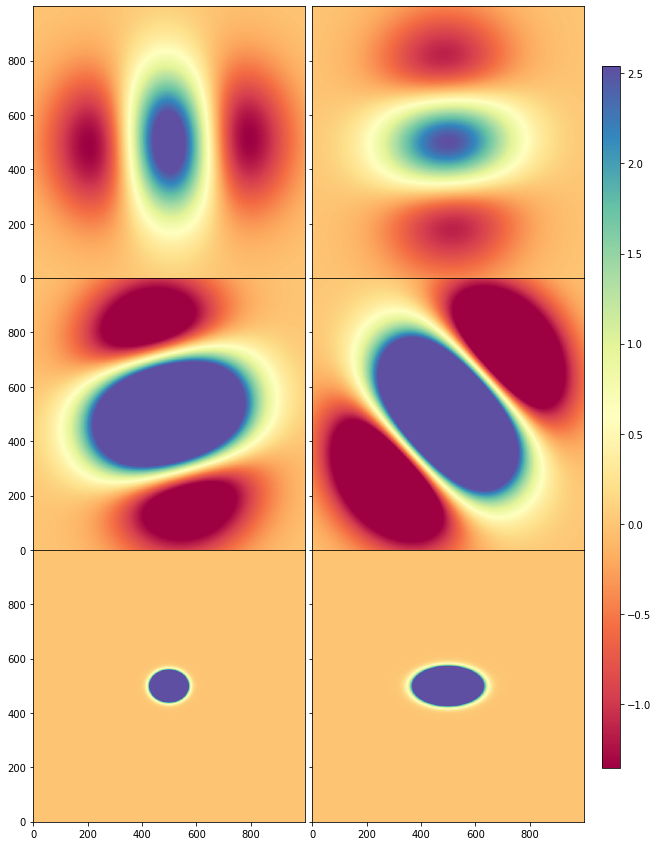

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(10, 15))
fig.subplots_adjust(hspace=0, wspace=0)

im = axes[0, 0].imshow(Ku_11, origin='lower', cmap='Spectral', interpolation='nearest', vmin=vmin, vmax=vmax)
im = axes[0, 1].imshow(Ku_22, origin='lower', cmap='Spectral', interpolation='nearest', vmin=vmin, vmax=vmax)

im = axes[1, 0].imshow(Ku_110, origin='lower', cmap='Spectral', interpolation='nearest', vmin=vmin, vmax=vmax)
im = axes[1, 1].imshow(Ku_220, origin='lower', cmap='Spectral', interpolation='nearest', vmin=vmin, vmax=vmax)

im = axes[2, 0].imshow(Ku, origin='lower', cmap='Spectral', interpolation='nearest', vmin=vmin, vmax=vmax)
im = axes[2, 1].imshow(Kv, origin='lower', cmap='Spectral', interpolation='nearest', vmin=vmin, vmax=vmax)

cb_ax = fig.add_axes([0.92, 0.175, 0.025, 0.65])
cbar = fig.colorbar(im, cax=cb_ax)
plt.show()

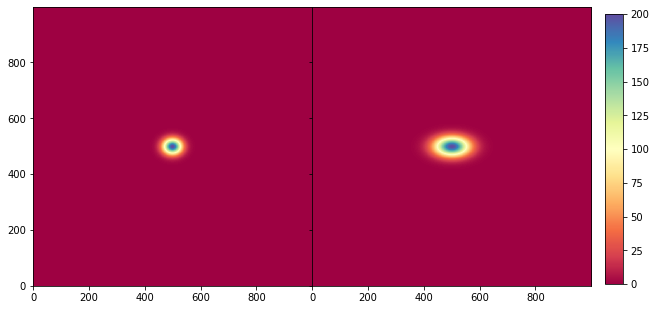

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10, 15))
fig.subplots_adjust(hspace=0, wspace=0)

vmin = Ku.min()
vmax = Ku.max()

im = axes[0].imshow(Ku, origin='lower', cmap='Spectral', interpolation='nearest', vmin=vmin, vmax=vmax)
im = axes[1].imshow(Kv, origin='lower', cmap='Spectral', interpolation='nearest', vmin=vmin, vmax=vmax)

cb_ax = fig.add_axes([0.92, 0.375, 0.025, 0.25])
cbar = fig.colorbar(im, cax=cb_ax)
plt.show()

In [12]:
theta

{'sigma_s': 103.22017098268992,
 'sigma_x': 0.1709823892942634,
 'sigma_y': 0.1867657764375329,
 'phi': -0.02522059270031203,
 'sigma_w': 4.473886785241184}

In [13]:
theta0

{'sigma_s': 339.8528316219861,
 'sigma_x': 0.2615284063080422,
 'sigma_y': 0.19497544749799348,
 'phi': 0.5192476843607524,
 'sigma_w': 1.0}

In [14]:
GP.utheta

{'var_s': 200.1454291623629,
 'sigma_x': 0.024285927405040597,
 'sigma_y': 0.02001684959919461,
 'phi': 0.0,
 'var_w': 4.228158476742845}

In [15]:
GP.vtheta

{'var_s': 200.1416221677148,
 'sigma_x': 0.04429556540932483,
 'sigma_y': 0.0247572591869507,
 'phi': 2.7903205316492487e-18,
 'var_w': 3.35437591709216}